## Global Terrorism Database (Focusing on Cyber-Related Terrorism):

This dataset is from Global Terrorism Database curated by the University of Maryland:

National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd.

In this notebook, we will try and isolate data related to cyber-warfare or hacking events.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 1. Importing, Cleaning and General Overview:

In [17]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx', 
                   usecols = 'A:D, F, H:M, S:W, AA:AD, AI:AP, BG, BM:BN, BQ:BT, CD:CG, CU, CX, DA')                                                                                         

In [27]:
# Looking at the size and amount of null values in our dataset:

pd.set_option('max_rows', 47)

na_values = df.isna().sum()
shape = df.shape

In [137]:
# Renaming for usability:

df = pd.DataFrame(data.rename({'eventid':'event_id', 'iyear':'year', 'imonth':'month',
             'iday':'day', 'extended': '24+hrs', 'region_txt':'region', 'provstate':'region_2',
             'doubtterr':'doubt', 'attacktype1':'attack_type1', 'attacktype1_txt':'attack_type1_txt',
             'attacktype2':'attack_type2', 'targtype1':'target_1', 'targtype1_txt':'target_type1_txt', 
             'targsubtype1':'sub_target', 'targsubtype1_txt':'sub_target_txt', 'target1':'specific_target',
             'natlty1_txt':'victim_nationality', 'weaptype1':'weapon', 'weapdetail': 'weapon_detail',
             'gname': 'group_name', 'guncertain1':'group_attrib_crtainty'}, axis = 1))

# Replacing some of the null values that still exist in the 'claimed' column to match 'uncertain' values:

# data.replace({'claimed': {np.nan:-9.0}}, inplace = True)

### 2. Preliminary Exploration and Visualization:

##### A. Isolating relevant data:

> Here, we want to try to isolate the rows whose summaries relate directly to what we want to analyze:

In [40]:
# Regex to isolate qualifying data:

import re

print(data.summary.str.contains('cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+',
                         flags = re.IGNORECASE, regex = True).value_counts())

False    172205
True       9486
Name: summary, dtype: int64


In [41]:
# Creating a mask which represents the results from our search above:

mask = data.summary.str.contains(r'(cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+)', 
                           flags = re.IGNORECASE)

# Creating a new, filtered dataframe with this specific information:
cyber_data1 = data[mask]

In [42]:
# Getting some of the data-types straightened out:

cyber_top30['doubt'] = cyber_top30.doubt.astype('int64')
cyber_top30['attack_type2'] = cyber_top30.attack_type2.astype('int64') 
cyber_top30['sub_target'] = cyber_top30.sub_target.astype('int64')
cyber_top30['group_attrib_crtainty'] = cyber_top30.group_attrib_crtainty.astype('int64')
cyber_top30['claimed'] = cyber_top30.claimed.astype('int64')

##### B. First Visuals:

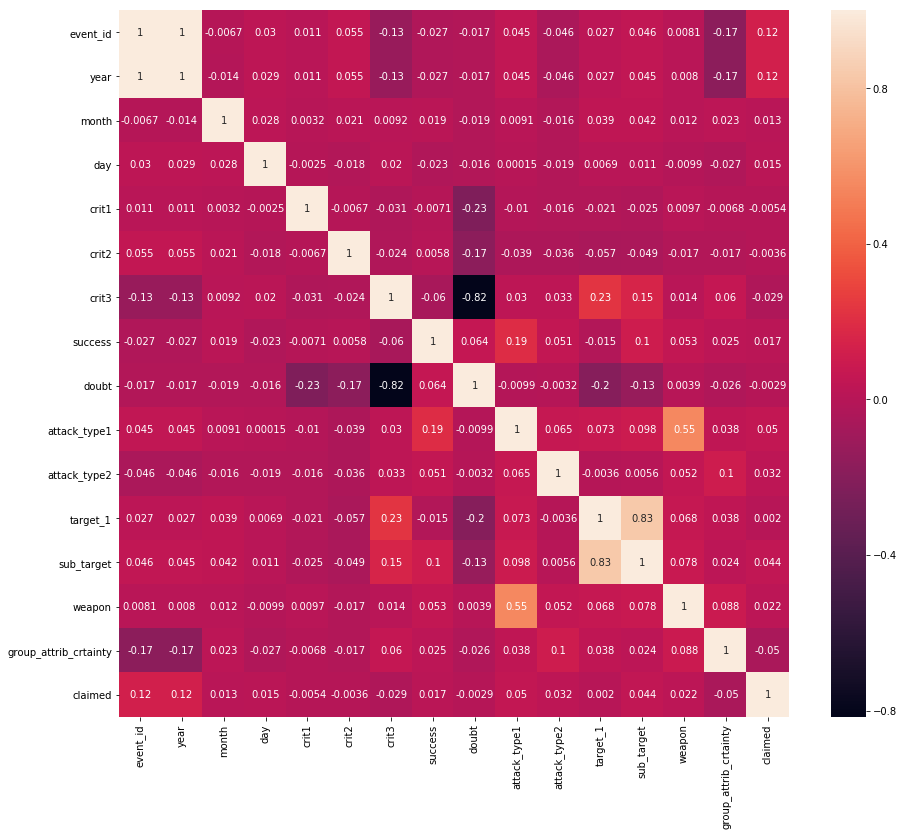

In [43]:
# Correlation map: Not much here, might have to do some more poking around/feature engineering:

f, ax = plt.subplots(figsize = (15, 13))
sns.heatmap(cyber_top30.corr(), annot = True)

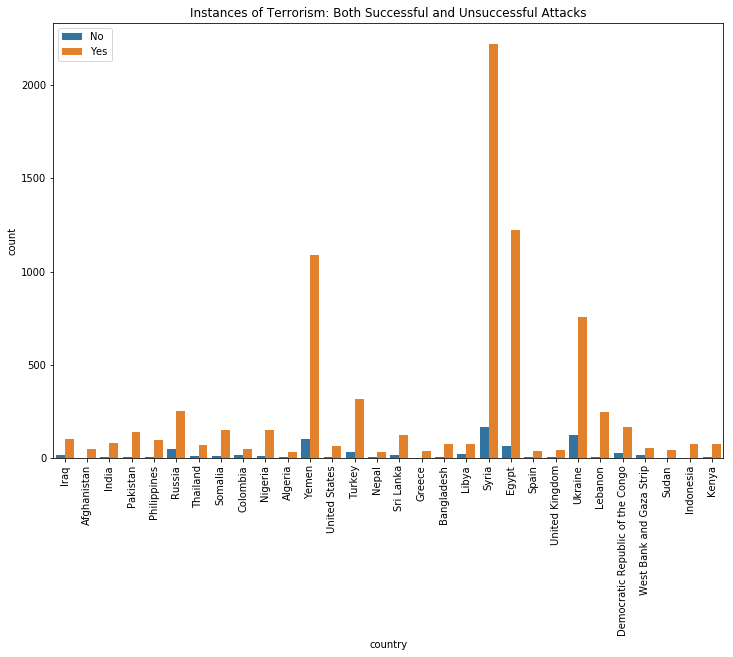

In [44]:
# Instances of Terrorism with Success Rate:

f, ax = plt.subplots(figsize = (12, 8))
sns.countplot(x = 'country', hue = 'success', data = cyber_top30)
ax.set_xticklabels(labels = top_30_countries[0:], rotation = '90')
ax.legend(labels = ['No', 'Yes'])
ax.set_title('Instances of Terrorism: Both Successful and Unsuccessful Attacks')
plt.show()

In [45]:
# Most prolific groups:

actives = cyber_data1.group_name.value_counts().head(10).drop('Unknown')
mask3 = cyber_data1.group_name.map(lambda x: x in actives)
actives_df = cyber_data1[mask3]

In [46]:
name_dict = {'Taliban':0, 'CPI-Maoist':1, 'Maoists':2, 'ISIL':3,
             'NPA':4, 'Al-Shabaab':5, 'TTP':6, 'FARC':7, 'Boko Haram':8}

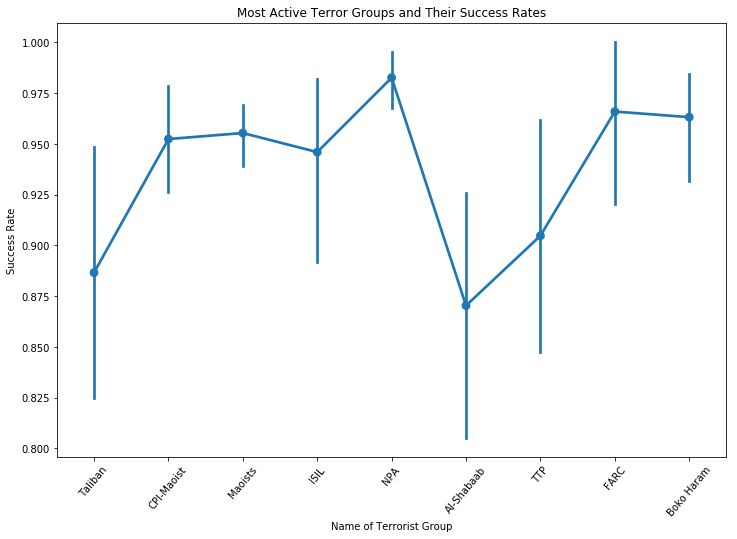

In [47]:
f, ax = plt.subplots(figsize = (12, 8))
sns.pointplot(x = 'group_name', y = 'success', data = actives_df)
ax.set_xticklabels(labels = name_dict, rotation = '50')
ax.set_xlabel('Name of Terrorist Group')
ax.set_ylabel('Success Rate')
ax.set_title('Most Active Terror Groups and Their Success Rates')
plt.show()

### 3. First Models:

In [160]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

In [179]:
# Makin dummies:

cyber_dummy = cyber_data1.drop(['event_id', 'summary', 'motive', 'attack_type2', 'specific_target'], axis = 1)
cyber_dummy = pd.get_dummies(cyber_dummy)
beta = cyber_dummy.isnull().sum()

In [178]:
actives_df.shape

(2071, 30)

In [180]:
cyber_dummy.dropna(inplace = True)
     
X = cyber_dummy.drop(['success'], axis = 1)
y = cyber_dummy['success']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
        
    # Fitting the model:
    
forest_cl = RandomForestClassifier()
forest_cl.fit(X_train, y_train)
y_pred_ = forest_cl.predict(X_test)
    
    # Evaluation:
    
confusion_forest = confusion_matrix(y_test, y_pred_, labels = [0, 1])
forest_cv = cross_val_score(forest_cl, X_train, y_train, cv = 5)
forest_train_score = forest_cl.score( X_train, y_train)
forest_test_score = forest_cl.score( X_test, y_test)
    


In [182]:
plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(forest_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(forest_cv.mean(),
                                                                      plusminus, forest_cv.std()))
print("The cv scores are: \n{}".format(forest_cv))
print("\nThe test score is: {:.2%}".format(forest_test_score))

forest_confusion_df = pd.DataFrame(confusion_forest)

FP = forest_confusion_df.loc[0, 1]
FN = forest_confusion_df.loc[1, 0]
NegT = forest_confusion_df.iloc[0].sum()
PosT = forest_confusion_df.iloc[1].sum()

print(forest_confusion_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))

feat_imp = pd.DataFrame(forest_cl.feature_importances_.round(2), index = X_train.columns, columns = ["Importances"])
display(feat_imp.sort_values('Importances', ascending = False))

The training score is: 99.64%

The mean cross-validation score is: 93.76% ±0.61%

The cv scores are: 
[0.93085502 0.93377976 0.93824405 0.94866071 0.93670886]

The test score is: 93.57%
    0     1
0  72   126
1  18  2024
False Positive (Type I Error): 126
(63.64%)

False Negative (Type II Error): 18
(0.88%)



Importances
attack1_dscr_Assassination                                 0.08
target_1dscr_Military                                      0.05
day                                                        0.03
month                                                      0.03
year                                                       0.02
attack_type1                                               0.02
sub_target                                                 0.02
weapon                                                     0.02
target_1                                                   0.01
weapon_detail_An improvised explosive device wa...         0.01
claimed                                                    0.01
group_name_Unknown                                         0.01
country_Iraq                                               0.01
country_Ireland                                            0.01
corp1_National Uprising Movement (NUM)                     0.00
corp1_National United Front for an Independent,...         0.00
corp1_National Youth Service Corps                         0.00
corp1_National Youth Service Corps (NYSC)                  0.00
corp1_Nationalist Action Party (MHP)                       0.00
corp1_Nationalist Movement Party                           0.00
corp1_Navin Pratharnik School                              0.00
corp1_Nationalist Movement Party (MHP)                     0.00
corp1_Nationalist Socialist Council of Nagaland...         0.00
corp1_Naval Ammunition Depot                               0.00
corp1_National Solidarity Programme (NSP)                  0.00
corp1_Neiva Gas Company                                    0.00
corp1_Nepal Agricultural Research Council (NARC)           0.00
corp1_Nepal Constituent Assembly                           0.00
corp1_National Transmission Corporation (TransCo)          0.00
corp1_National Socialist Council of Nagaland: I...         0.00
...                                                         ...
city_Mongtat                                               0.00
city_Montecristo                                           0.00
city_Mirazai                                               0.00
city_Montgomery                                            0.00
city_Monywa                                                0.00
city_Morang district                                       0.00
city_Morangi                                               0.00
city_Moratuwa                                              0.00
city_Morcote                                               0.00
city_Moreh                                                 0.00
city_Mohmand district                                      0.00
city_Mohammad Agha district                                0.00
city_Mohammad Aga district                                 0.00
city_Mohallah Sunehri                                      0.00
city_Mirchaiya                                             0.00
city_Mirza Wulang                                          0.00
city_Mirzapur                                              0.00
city_Mishada                                               0.00
city_Missezai                                              0.00
city_Mitala Maria                                          0.00
city_Mitrovica                                             0.00
city_Mitzitón                                              0.00
city_Miya Nishin district                                  0.00
city_Mizan district                                        0.00
city_Mlang                                                 0.00
city_Mobbar                                                0.00
city_Mocoa                                                 0.00
city_Mogadishu                                             0.00
city_Mogasishu                                             0.00
group_name_Zionist Resistance Fighters                     0.00

[10199 rows x 1 columns]

In [188]:
cyber_data1.describe(include = [np.object])

country      region region_2     city  \
count     9486        9486     9486     9440   
unique     123          12      788     4035   
top       Iraq  South Asia  Baghdad  Baghdad   
freq      2398        3748      796      792   

                                                  summary       attack1_dscr  \
count                                                9486               9486   
unique                                               9271                  9   
top     07/00/2014: Sometime between July 1 and July 1...  Bombing/Explosion   
freq                                                   27               5374   

                       target_1dscr                subtarget_dscr  \
count                          9486                          9005   
unique                           19                           108   
top     Private Citizens & Property  Unnamed Civilian/Unspecified   
freq                           3139                          1077   

                 corp1 specific_target victim_nationality  \
count             8051            9472               9372   
unique            2617            5617                137   
top     Not Applicable       Civilians               Iraq   
freq              1205             689               2305   

                                  weapon_detail group_name motive  
count                                      5954       9486   9486  
unique                                     1880        458   2020  
top     A roadside bomb was used in the attack.    Unknown    nan  
freq                                       1556       5305   3783